<a href="https://colab.research.google.com/github/RummanAli/Label-Super-Resolution-Network/blob/master/Label_Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/lcm_cvpr2019_small.zip" .

cp: error reading '/content/drive/My Drive/lcm_cvpr2019_small.zip': Input/output error


In [0]:
!wget https://lilablobssc.blob.core.windows.net/lcmcvpr2019/lcm_cvpr2019_small.zip

--2019-08-24 06:26:15--  https://lilablobssc.blob.core.windows.net/lcmcvpr2019/lcm_cvpr2019_small.zip
Resolving lilablobssc.blob.core.windows.net (lilablobssc.blob.core.windows.net)... 13.85.88.16
Connecting to lilablobssc.blob.core.windows.net (lilablobssc.blob.core.windows.net)|13.85.88.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75224940135 (70G) [application/octet-stream]
Saving to: ‘lcm_cvpr2019_small.zip’

lcm_cvpr2019_small. 100%[===================>]  70.06G  15.7MB/s    in 67m 19s 

2019-08-24 07:33:34 (17.8 MB/s) - ‘lcm_cvpr2019_small.zip’ saved [75224940135/75224940135]



In [0]:
!cp '/content/lcm_cvpr2019_small.zip' '/content/drive/My Drive'

In [0]:
from zipfile import ZipFile
my = ZipFile("lcm_cvpr2019_small.zip")
my.extractall()

In [0]:
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import numpy as np


In [0]:
def largetosmall(image_list):
  CroppedImages = []
  for image in image_list:
    counter =0
    image = image.resize((7440,6000))
    a,b = image.size
    y=0
    x=0
    while y <b:
      while x <a:
        imagea = image.crop((x,y,x+224,y+224))
        imagea = np.array(imagea)
        CroppedImages.append(imagea)
        #mapped_image = mapping(imagea)
        #onehot.append(to_categorical(mapped_image,num_classes = 22))
        x=x+224
      y=y+224
      x=0
  return CroppedImages

In [0]:
def mapping(h):
  h[h==11] = 1
  h[h==12] = 2
  h[h==21] = 3
  h[h==22] = 4
  h[h==23] = 5
  h[h==24] = 6
  h[h==31] = 7
  h[h==41] = 8
  h[h==42] = 9
  h[h==43] = 10
  h[h==51] = 11
  h[h==52] = 12
  h[h==71] = 13
  h[h==72] = 14
  h[h==73] = 15
  h[h==74] = 16
  h[h==81] = 17
  h[h==82] = 18
  h[h==90] = 19
  h[h==95] = 20
  h[h==255]= 21
  return h

In [0]:
import os

In [0]:
def tifextractor(path,last_name):  
  TifRetriever = []
  for file in os.listdir(path):
    if file.endswith(last_name):
      x= (os.path.join(path, file))
      a = Image.open(x)
      TifRetriever.append(a)
  return TifRetriever
      
  

In [0]:
def toonehot(class_list,image_array):
  np.expand_dims(image_array,axis = -1)
  for clas in class_list:
    if(clas==0):
      one_hot = np.all(image_array == clas,axis = -1)
      one_hot = np.expand_dims(one_hot,-1)
    else:
      c = np.all(image_array==clas,axis=-1)
      c=  np.expand_dims(c,-1)
      one_hot = np.concatenate((c,one_hot),axis=3)
  
  return one_hot    
    
    
    

In [0]:
from tensorflow.keras.layers import Input, AveragePooling2D,Conv2D,Conv2DTranspose,UpSampling2D,Cropping2D,concatenate, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [0]:
X=[]
y=[]

In [0]:
states = [
    "de_1m_2013_train_tiles", # 107 tiles
    
    #"ny_1m_2013_train_tiles", # 407 tiles
    #"md_1m_2013_train_tiles", # 691 tiles
    #"pa_1m_2013_train_tiles", # 2239 tiles
    #"wv_1m_2014_train_tiles", # 292 tiles
    #"va_1m_2014_train_tiles"  # 1238 tiles
]

path = "md_1m_2013_train_tiles"
h=tifextractor(path,"nlcd.tif")
h=largetosmall(h)
y.append(h)
n=tifextractor(path,"naip.tif")
n=largetosmall(n)
X.append(n)

In [0]:

len(X[2])

22950

In [0]:
def modelunet(input_shape):
    input_x=Input(input_shape)
	  a1 = Conv2D(64,3,strides=(1,1),activation = 'relu',kernel_initializer='glorot_uniform')(input_x)
	  a2 = Conv2D(64,3,strides=(1,1),activation = 'relu',kernel_initializer='glorot_uniform')(a1)
	  a3 = MaxPooling2D(2)(a2)
	
	  b1 = Conv2D(128,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(a3)
	  b2 = Conv2D(128,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(b1)
	  b3 =MaxPooling2D(2)(b2)
	
	  c1 = Conv2D(256,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(b3)
	  c2 = Conv2D(256,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(c1)
	  c3 = MaxPooling2D(2)(c2)
	
	  d1 = Conv2D(512,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(c3)
	  d2 = Conv2D(512,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(d1)
	  d3 = MaxPooling2D(2)(d2)
	
	  e1 = Conv2D(1024,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(d3)
	  e2 = Conv2D(1024,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(e1)
	  e3 = Conv2D(512,2,activation = 'relu' ,padding = 'same', kernel_initializer = 'glorot_uniform')(UpSampling2D(size = (2,2)))
	
	  e4 = Cropping2D(4)(d2)
	
	  f1 = concatenate([e4,e3],axis = 3)
	  f2 = Conv2D(512,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(f1)
	  f3 = Conv2D(512,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(f2)
	  f4 = Conv2D(256,2,activation = 'relu' ,padding = 'same', kernel_initializer = 'glorot_uniform')(UpSampling2D(size = (2,2)))
	  f5 = Cropping2D(16)(c2)
	
	  g1 = concatenate([f5,f4],axis = 3)
	  g2 = Conv2D(256,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(g1)
	  g3 = Conv2D(256,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(g2)
	  g4 = Conv2D(128,2,activation = 'relu', padding = 'same' , kernel_initializer = 'glorot_uniform')(UpSampling2D(size = (2,2)))
	  g5 = Cropping2D(40)(b2)
	
	  h1 = concatenate([g5,g4],axis = 3)
	  h2 = Conv2D(128,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(h1)
	  h3 = Conv2D(128,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(h2)
	  h4 = Conv2D(64,2,activation = 'relu', padding = 'same' , kernel_initializer = 'glorot_uniform')(UpSampling2D(size = (2,2)))
	  h5 = Cropping2D(88)(a2)
	
	  i1 = concatenate([h4,h5],axis = 3)
	  i2 = Conv2D(64,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(i1)
	  i3 = Conv2D(64,3,strides=(1,1),activation = 'relu' , kernel_initializer = 'glorot_uniform')(i2)
	  i4 = Conv2D(2,3,strides=(1,1),activation = 'softmax' , kernel_initializer = 'glorot_uniform')(i3)
	
	
	  model = Model(inputs = input_x,outputs = i4)
	  return model

In [0]:

def model2(input_shape):
    input_x = Input(input_shape)
    X=Conv2D(64,3,strides = (1,1),padding = 'same',data_format = "channels_last" ,activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_1a")(input_x)
    X=Conv2D(64,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_1b")(X)
    X=MaxPooling2D((2,2), name = "fc_1c")(X)
    X=Conv2D(128,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_2a")(X)
    X=Conv2D(128,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_2b")(X)
    X=MaxPooling2D((2,2), name = "fc_2c")(X)
    X=Conv2D(256,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_3a")(X)
    X=Conv2D(256,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_3b")(X)
    X=Conv2D(256,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_3c")(X)
    fc_3d=MaxPooling2D((2,2), name = "fc_3d")(X)
    X=Conv2D(512,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_4a")(fc_3d)
    X=Conv2D(512,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_4b")(X)
    X=Conv2D(512,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_4c")(X)
    fc_4d=MaxPooling2D((2,2), name = "fc_4d")(X)
    X=Conv2D(512,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_5a")(fc_4d)
    X=Conv2D(512,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_5b")(X)
    X=Conv2D(512,3,strides = (1,1),padding = 'same',activation  = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_5c")(X)
    X=MaxPooling2D((2,2), name = "fc_5d")(X)
    X=Conv2D(4096,1,activation = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_6")(X)
    X=Dropout(0.5)(X)
    X=Conv2D(4096,1,activation = 'relu', use_bias  =True,kernel_initializer='glorot_uniform', name = "fc_7")(X)
    X=Dropout(0.5)(X)
    fc_8=Conv2D(2,1,strides = (1,1),activation ='relu' , use_bias = True,kernel_initializer='glorot_uniform', name = "fc_8")(X)
    fc_9=Conv2DTranspose(512,4,strides = (2,2),activation ='relu',padding = 'same',use_bias = True,kernel_initializer='glorot_uniform', name ="fc_9")(fc_8)
    fc_9_skip_connected  = tf.add(fc_9,fc_4d)
    fc_10=Conv2DTranspose(256,4,strides = (2,2),activation ='relu' , padding = 'same' ,use_bias = True,kernel_initializer='glorot_uniform', name = "fc_10")(fc_9_skip_connected)
    fc_10_skip_connected = tf.add(fc_10,fc_3d)
    X = Conv2DTranspose(3,16,strides = (8,8),activation ='softmax' , padding ='same',kernel_initializer='glorot_uniform', name = "fc_11")(fc_10_skip_connected)
    model = Model(inputs = input_x,outputs = X,name = 'MyModel')
    return model

In [0]:
def unet(input_x):
    inputs = Input(input_x)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(22, 3, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    model = Model(input = inputs, output = conv9)
    return model

In [0]:
h=tifextractor("/content/de_1m_2013_train_tiles","nlcd.tif")
h=largetosmall(h)
class_list = [0, 11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 51, 52, 71, 72, 73, 74, 81, 82, 90, 95, 255]
#y= np.expand_dims(h,-1)
#y=toonehot(class_list,y[:5000])
X=tifextractor("/content/de_1m_2013_train_tiles/m_3807519_sw_18_1_20130915_naip.tif","naip.tif")
X=largetosmall(X)
X=X[:10000]

In [0]:
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
from sklearn.utils import shuffle
X, h = shuffle(X[:1000],dummy_h, random_state=0)

In [0]:
y = np.expand_dims(h,axis=-1)

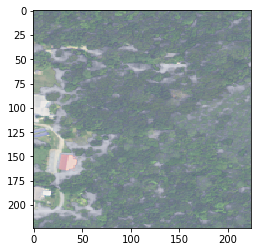

In [0]:
plt.imshow(X[6])

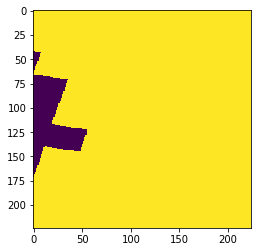

In [0]:
plt.imshow(h[5])

In [0]:
a[1].shape

IndexError: ignored

In [0]:
y[4][200][76     ]

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

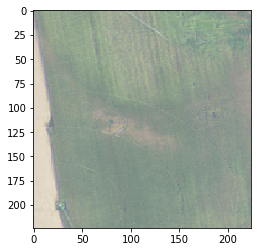

In [0]:
plt.imshow(X[1])

In [0]:
segmodel = unet(X[1].shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
Mean = np.array([[0.00,0.00,0.00,0.00],
		[0.97,0.01,0.01,0.02], 
		[0.00,0.00,1.00,0.00], 
		[0.00,0.42,0.46,0.11], 
		[0.01,0.31,0.34,0.35], 
		[0.01,0.14,0.21,0.63], 
		[0.01,0.03,0.07,0.89], 
		[0.09,0.13,0.45,0.32], 
		[0.00,0.92,0.06,0.01], 
		[0.00,0.94,0.05,0.01], 
		[0.00,0.92,0.06,0.02], 
		[0.00,0.50,0.50,0.00], 
		[0.00,0.71,0.26,0.03], 
		[0.01,0.38,0.54,0.07], 
		[0.00,0.50,0.50,0.00],
		[0.00,0.00,1.00,0.00], 
		[0.00,0.00,1.00,0.00], 
		[0.00,0.11,0.86,0.03], 
		[0.00,0.11,0.86,0.03], 
		[0.01,0.90,0.08,0.00], 
		[0.11,0.07,0.81,0.01], 
		[0.00,0.00,0.00,0.00]])
		
Variance = np.array([[0.00,0.00,0.00,0.00], 
			[0.15,0.06,0.06,0.13], 
			[0.00,0.00,0.10,0.00], 
			[0.05,0.34,0.33,0.13], 
			[0.06,0.24,0.21,0.18], 
			[0.07,0.17,0.19,0.22], 
			[0.07,0.07,0.14,0.17], 
			[0.26,0.26,0.41,0.40], 
			[0.03,0.19,0.16,0.07], 
			[0.03,0.18,0.16,0.05], 
			[0.05,0.18,0.15,0.06], 
			[0.00,0.10,0.10,0.00], 
			[0.05,0.35,0.33,0.09], 
			[0.09,0.40,0.39,0.18], 
			[0.00,0.10,0.10,0.00], 
			[0.00,0.00,0.10,0.00], 
			[0.00,0.00,0.10,0.00], 
			[0.02,0.21,0.23,0.09], 
			[0.03,0.22,0.24,0.09], 
			[0.07,0.22,0.21,0.03], 
			[0.21,0.22,0.29,0.05], 
			[0.00,0.00,0.00,0.00]])

In [0]:
 nlcd_class_weights = {
        
        8:0.5, 
        17:0.5, 18:0.5,
 }

In [0]:
def sr_loss(nlcd_class_weights, nlcd_means, nlcd_vars, boundary=0):
    '''Calculate superres loss according to ICLR paper'''

    def ddist(prediction, c_interval_center, c_interval_radius):
        return K.relu(K.abs(prediction - c_interval_center) - c_interval_radius)
    
    def loss(y_true, y_pred):
        
        super_res_crit = 0
        mask_size =  K.expand_dims(K.sum(y_true, axis=(1,2,3)) + 10, -1) # shape 16x1

        for nlcd_idx in range(nlcd_class_weights.shape[0]):

            c_mask = K.expand_dims(y_true[:,:,:,nlcd_idx], -1) # shape 32x240x240x1
            c_mask_size = K.sum(c_mask, axis=(1,2)) + 0.000001 # shape 32x1
            
            c_interval_center = nlcd_means[nlcd_idx] # shape 4,
            c_interval_radius = nlcd_vars[nlcd_idx] # shape 4,

            masked_probs = y_pred * c_mask # (32x240x240x4) * (32x240x240x1) --> shape (32x240x240x4)
            
            # Mean mean of predicted distribution
            mean = K.sum(masked_probs, axis=(1,2)) / c_mask_size # (16x5) / (16,1) --> shape 16x5
            
            # Mean var of predicted distribution
            var = K.sum(masked_probs * (1.-masked_probs), axis=(1,2)) / (c_mask_size * c_mask_size) # (16x5) / (16,1) --> shape 16x5
            
            c_super_res_crit = 0.5*(K.square(c_interval_center-mean))/(var*var+c_interval_radius*c_interval_radius)+0.5*K.log(2*(c_interval_radius*c_interval_radius)*22/7)
            #c_super_res_crit = K.square(ddist(mean, c_interval_center, c_interval_radius)) # calculate numerator of equation 7 in ICLR paper
            #c_super_res_crit = c_super_res_crit / (var + (c_interval_radius * c_interval_radius) + 0.000001) # calculate denominator
            #c_super_res_crit = c_super_res_crit + K.log(var + 0.03) # calculate log term
            #c_super_res_crit = (c_super_res_crit * (c_mask_size / mask_size) * nlcd_class_weights[nlcd_idx]) # weight by the fraction of NLCD pixels and the NLCD class weight
            
            super_res_crit = super_res_crit + c_super_res_crit # accumulate
        
        super_res_crit = K.sum(super_res_crit, axis=1) # sum superres loss across highres classes
        return super_res_crit
    
    return loss

In [0]:
segmodel.summary()

In [0]:
X = np.array(X)
y.shape


(10000, 224, 224, 1)

In [0]:
segmodel.compile(optimizer = Adam(lr=1e-6), loss = "categorical_crossentropy",metrics = ["accuracy"])
segmodel.fit(x = X,y = h, epochs =100 ,batch_size = 16)

Epoch 1/100
1000/1000 [==============================] - 115s 115ms/step - loss: 14.0977 - acc: 0.1249
Epoch 2/100
1000/1000 [==============================] - 111s 111ms/step - loss: 14.0976 - acc: 0.1249
Epoch 3/100
1000/1000 [==============================] - 111s 111ms/step - loss: 14.0971 - acc: 0.1249
Epoch 4/100
1000/1000 [==============================] - 111s 111ms/step - loss: 14.0967 - acc: 0.1249
Epoch 5/100
1000/1000 [==============================] - 111s 111ms/step - loss: 14.0965 - acc: 0.1249
Epoch 6/100
1000/1000 [==============================] - 111s 111ms/step - loss: 14.0962 - acc: 0.1249
Epoch 7/100
1000/1000 [==============================] - 111s 111ms/step - loss: 14.0961 - acc: 0.1249
Epoch 8/100
1000/1000 [==============================] - 111s 111ms/step - loss: 14.0959 - acc: 0.1249
Epoch 9/100
1000/1000 [==============================] - 111s 111ms/step - loss: 14.0963 - acc: 0.1249
Epoch 10/100
1000/1000 [==============================] - 111s 111ms/step

In [0]:
from keras.utils import plot_model
plot_model(segmodel, to_file='model.png', show_shapes=True)

In [0]:
a=0

In [0]:
a = np.expand_dims(X[1],axis =0)


In [0]:
a.shape

(1, 224, 224, 4)

In [0]:
y.shape

(5000, 224, 224, 22)

In [0]:
c=segmodel.predict(a)

In [0]:
c.shape

(1, 224, 224, 22)

In [0]:
c = np.squeeze(c,0)

In [0]:
c.shape

(224, 224, 22)

In [0]:
c[100][210]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.], dtype=float32)

In [0]:
a.shape

(1, 224, 224, 4)

In [0]:
class_list = np.array([[0,0,0],[0,11,0] ,[0,12,0],[0,21,0], [0,22,0], [0,23,0], [0,24,0], [0,31,0], [0,41,0], [0,42,0], [0,43,0], [0,51,0], [0,52,0], [0,71,0], [0,72,0], [0,73,0], [0,74,0], [0,81,0], [0,82,0], [0,90,0], [0,95,0],[0, 255,0]])

In [0]:
y[0][0][0]

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [0]:
one = y[0]

In [0]:
one.shape

(224, 224, 22)

In [0]:
f = np.argmax(c,axis =-1)

In [0]:
f.shape

(224, 224)

In [0]:
f

array([[21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       ...,
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21]])